Tom Barclay's xoflares on EPIC-246301900

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.4.4
1.0.4
3.9.3
2.0.3


In [ ]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

In [4]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

(3379,)


In [5]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [6]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [7]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

3255


In [8]:
yerr = np.abs(postgap.PDCSAP_FLUX_ERR/np.median(postgap.PDCSAP_FLUX_ERR) - 1)
print(yerr)

2594    0.016280
2595    0.016569
2596    0.016873
2597    0.016956
2598    0.016995
          ...   
3856    0.023091
3857    0.022657
3859    0.023501
3860    0.022514
3861    0.022021
Name: PDCSAP_FLUX_ERR, Length: 1071, dtype: float32


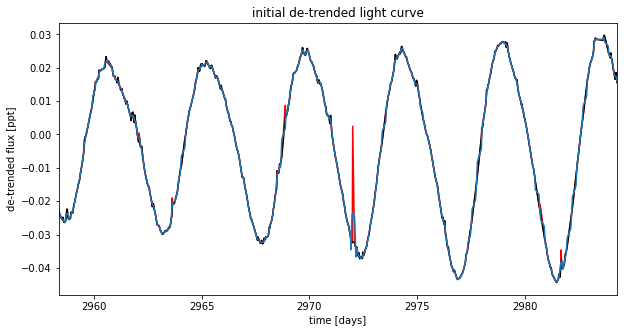

In [9]:
# get a smoothed version of the light curve
norm_y = normalize_flux(postgap.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 9, polyorder=3) #formerly window_length=13
resid = norm_y - smooth
mask = resid < 1.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(postgap.TIME, norm_y, "r")
plt.plot(postgap.TIME[mask], norm_y[mask], "k")
plt.plot(postgap.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
#plt.ylim(580000, 680000)
plt.xlim(postgap.TIME.min(), postgap.TIME.max());

In [10]:
def find_flares(lc):

    # find some flares
    mflare = resid < 1.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(postgap)

[-9.22488666 -7.69252203 -7.10000748 -2.82981383 -2.44161407  0.60269161
  0.68441788  0.82743912  2.21678828  6.38484257  6.65045428  9.16355177
  9.36786891  9.40873242 10.34859132 10.79808935 11.04327021] [0.00178984 0.0028274  0.00295116 0.00216592 0.00679164 0.00328939
 0.02599882 0.00294719 0.00294856 0.0024352  0.0029963  0.00206746
 0.00210535 0.00349106 0.00367626 0.0025279  0.00307705] [0.00277778 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778
 0.00277778 0.00277778 0.00277778 0.00416667 0.00416667 0.00277778
 0.00277778 0.00277778 0.00277778 0.00277778 0.00277778] 17


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

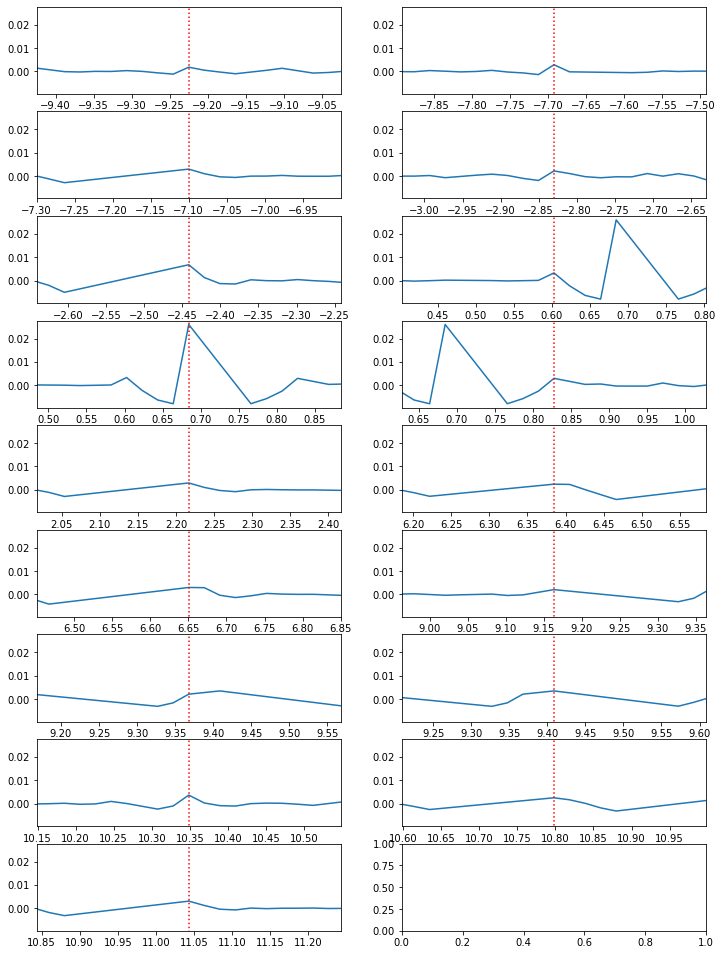

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

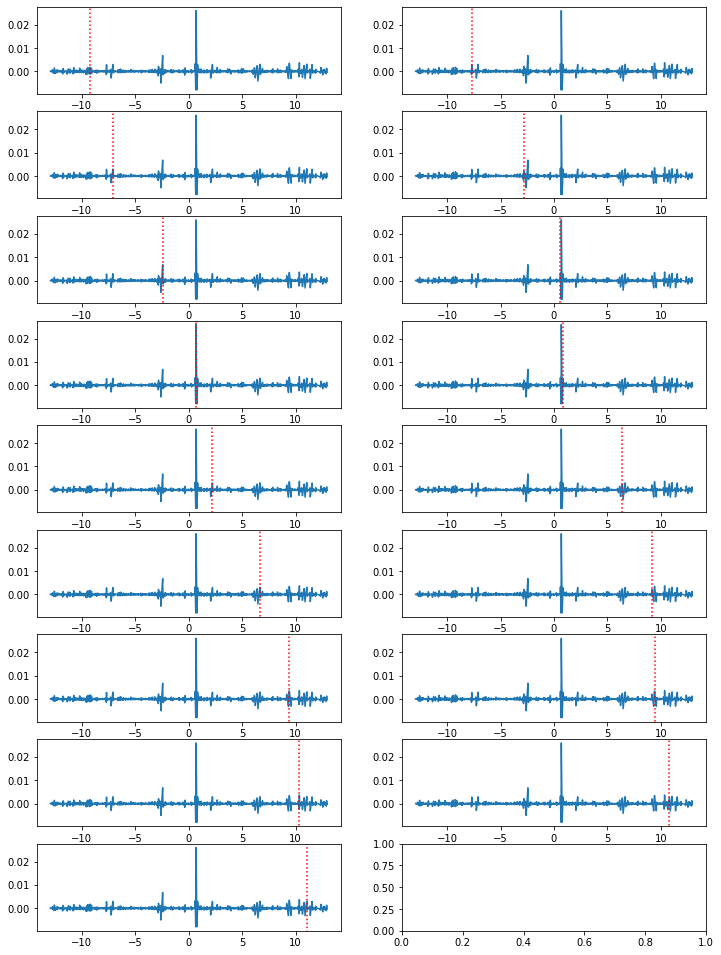

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')


In [205]:
# to deal with theano + pymc error (since pymc resets compute_test_value attribute)
theano.config.compute_test_value = 'ignore'


In [13]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7): 
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        #print(dt)
        tgrid = tt.shape_padright(time) + dt
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [9]:
def flare_lc_model(t, name=""):
    flare_lc = get_light_curve(t, tpeak, fwhm, ampl, oversample=7)
    pm_determ = pm.Deterministic("flare_lc"+name, flare_lc)

    if name=="":
        pm.Normal("obs"+name, mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    else:
        #pm.Normal("obs"+name, mu=flare_lc + mean, sd=tt.exp(2*logs2))
        pass

    map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    # per Tom's advice, sample 1/A & 1/FWHM for better performance
    map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl]) 
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])

    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=100000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=2,) # formerly draws=4
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

    with model:
        step = pm.NUTS(potential=potential, target_accept=0.9)
        trace = pm.sample(draws=400, tune=50, step=step, start=start, cores=2) #formerly draws=2400, tune=200

    return start, potential, trace, pm_determ

In [14]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=7)
    flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7)
    pm_determ = pm.Deterministic("flare_lc", flare_lc)
    pm_determ_pred = pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only

    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)

    map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    # per Tom's advice, sample 1/A & 1/FWHM for better performance
    map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl]) 
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])

    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=2,) # formerly draws=4
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

    #with model:
    #    step = pm.NUTS(potential=potential, target_accept=0.9)
    #    trace = pm.sample(draws=400, tune=50, step=step, start=start, cores=2) #formerly draws=2400, tune=200
    
    #start, potential, trace, pm_determ = flare_lc_model(x)
    #start_pred, potential_pred, trace_pred, pm_determ = flare_lc_model(t_plot, name='_pred') # for plotting

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -9.655267741027317e+19 -> -9.466546172688931e+19
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -9.466546172688931e+19 -> -9.463422278323926e+19
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -9.463422278323926e+19 -> -9.460442804175546e+19
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -9.460442804175546e+19 -> -9.460442804175546e+19


Finished [100%]: Average Loss = -6,109.7


In [15]:
start[0]['tpeak'] - 0.2

array([-9.42479067, -7.89249883, -7.30150694, -3.03180591, -2.64146687,
        0.40282194,  0.48439651,  0.62314719,  2.01746971,  6.1798532 ,
        6.44749623,  8.96234705,  9.16355097,  9.21113231, 10.15058005,
       10.59716881, 10.83666905])

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

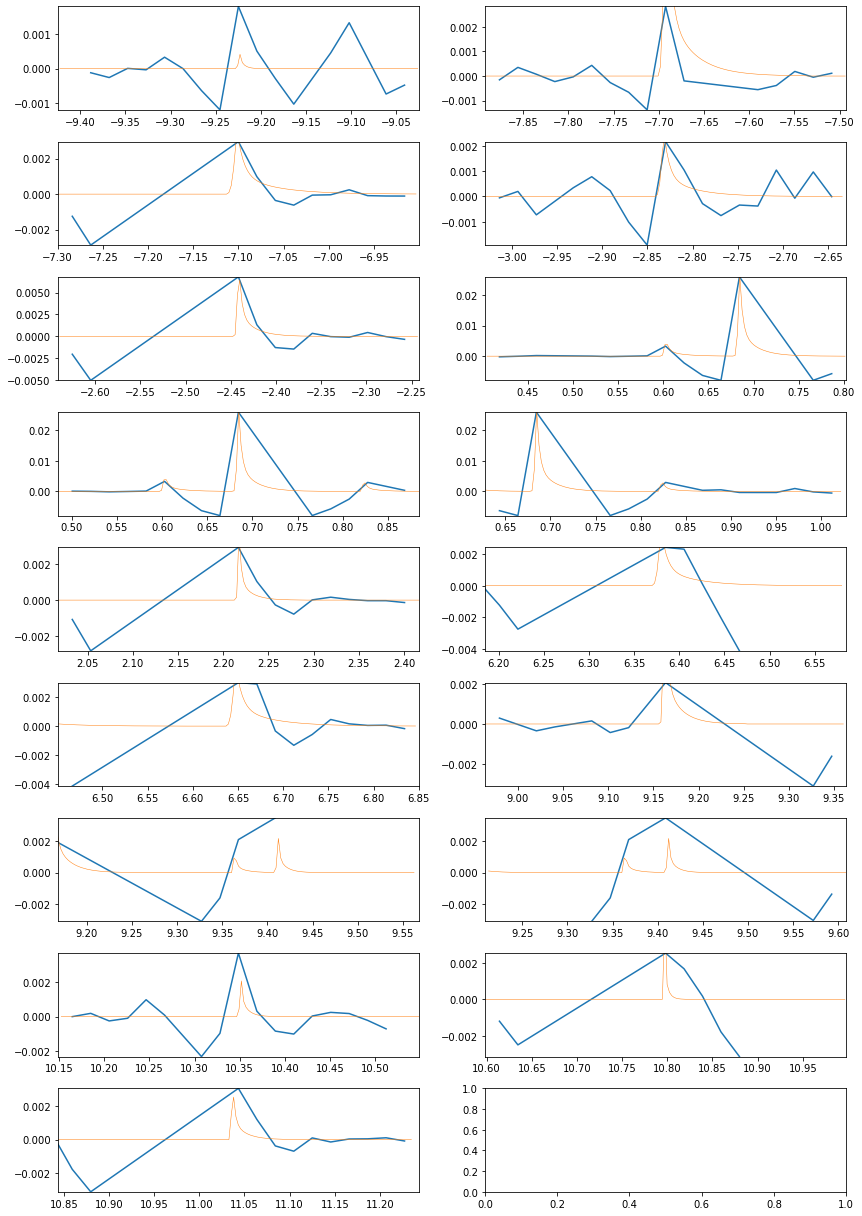

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 10000)

for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    timemask_t_plot = (t_plot >= tps[i]-0.2) * (t_plot < tps[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    with model:
        ax.plot(
            t_plot[timemask_t_plot], 
            pmx.eval_in_model(get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7), start[0])[timemask_t_plot],
            "C1", lw=0.5
        )
    #ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [14]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [17]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=2) #formerly draws=2400, tune=200

"""
with model:
    trace = pmx.sample(
        draws=500,
        tune=200,
        start=start,
        chains=100,
        cores=2,
        target_accept=0.95,
    )
"""

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 2 chains for 200 tune and 2_400 draw iterations (400 + 4_800 draws total) took 2118 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


'\nwith model:\n    trace = pmx.sample(\n        draws=500,\n        tune=200,\n        start=start,\n        chains=100,\n        cores=2,\n        target_accept=0.95,\n    )\n'

In [18]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],-6.070,0.691,-7.394,-4.700,0.010,0.007,4470.0,4307.0,4613.0,2968.0,1.00
logAmpl[1],-5.446,0.531,-6.337,-4.344,0.009,0.006,3364.0,3364.0,3696.0,2663.0,1.00
logAmpl[2],-5.395,0.518,-6.254,-4.304,0.010,0.007,2850.0,2850.0,3174.0,2664.0,1.00
logAmpl[3],-5.765,0.590,-6.910,-4.633,0.009,0.006,4294.0,4274.0,4495.0,2852.0,1.00
logAmpl[4],-4.416,0.460,-5.093,-3.520,0.018,0.013,648.0,648.0,745.0,828.0,1.00
logAmpl[5],-5.097,0.611,-6.125,-3.902,0.014,0.010,1903.0,1903.0,2201.0,2098.0,1.00
logAmpl[6],-3.045,0.454,-3.666,-2.197,0.068,0.049,45.0,44.0,44.0,148.0,1.04
logAmpl[7],-5.384,0.532,-6.306,-4.324,0.010,0.007,2791.0,2791.0,3125.0,2202.0,1.00
logAmpl[8],-5.388,0.511,-6.321,-4.409,0.010,0.007,2642.0,2642.0,2899.0,2015.0,1.00
logAmpl[9],-5.388,0.693,-6.444,-3.792,0.018,0.013,1523.0,1523.0,1744.0,1818.0,1.00


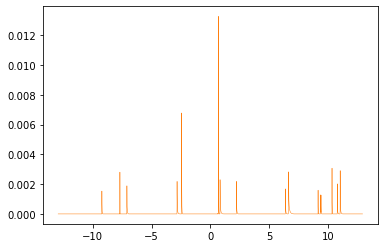

In [19]:
# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 5000)
with model:
    plt.plot(
        t_plot, pmx.eval_in_model(get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7), map_soln), "C1", lw=0.5
    )

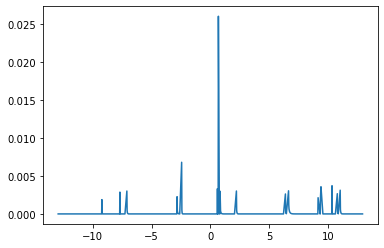

In [20]:
plt.plot(x, map_soln['flare_lc'])

<ErrorbarContainer object of 3 artists>

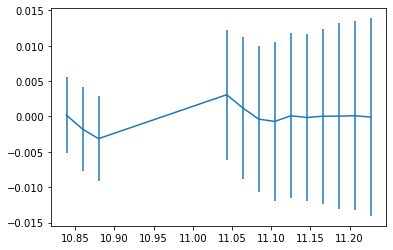

In [21]:
plt.errorbar(x[timemask], y[timemask], yerr=yerr[timemask]) #man, these are some bad errors
# did I normalize yerr correctly?

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

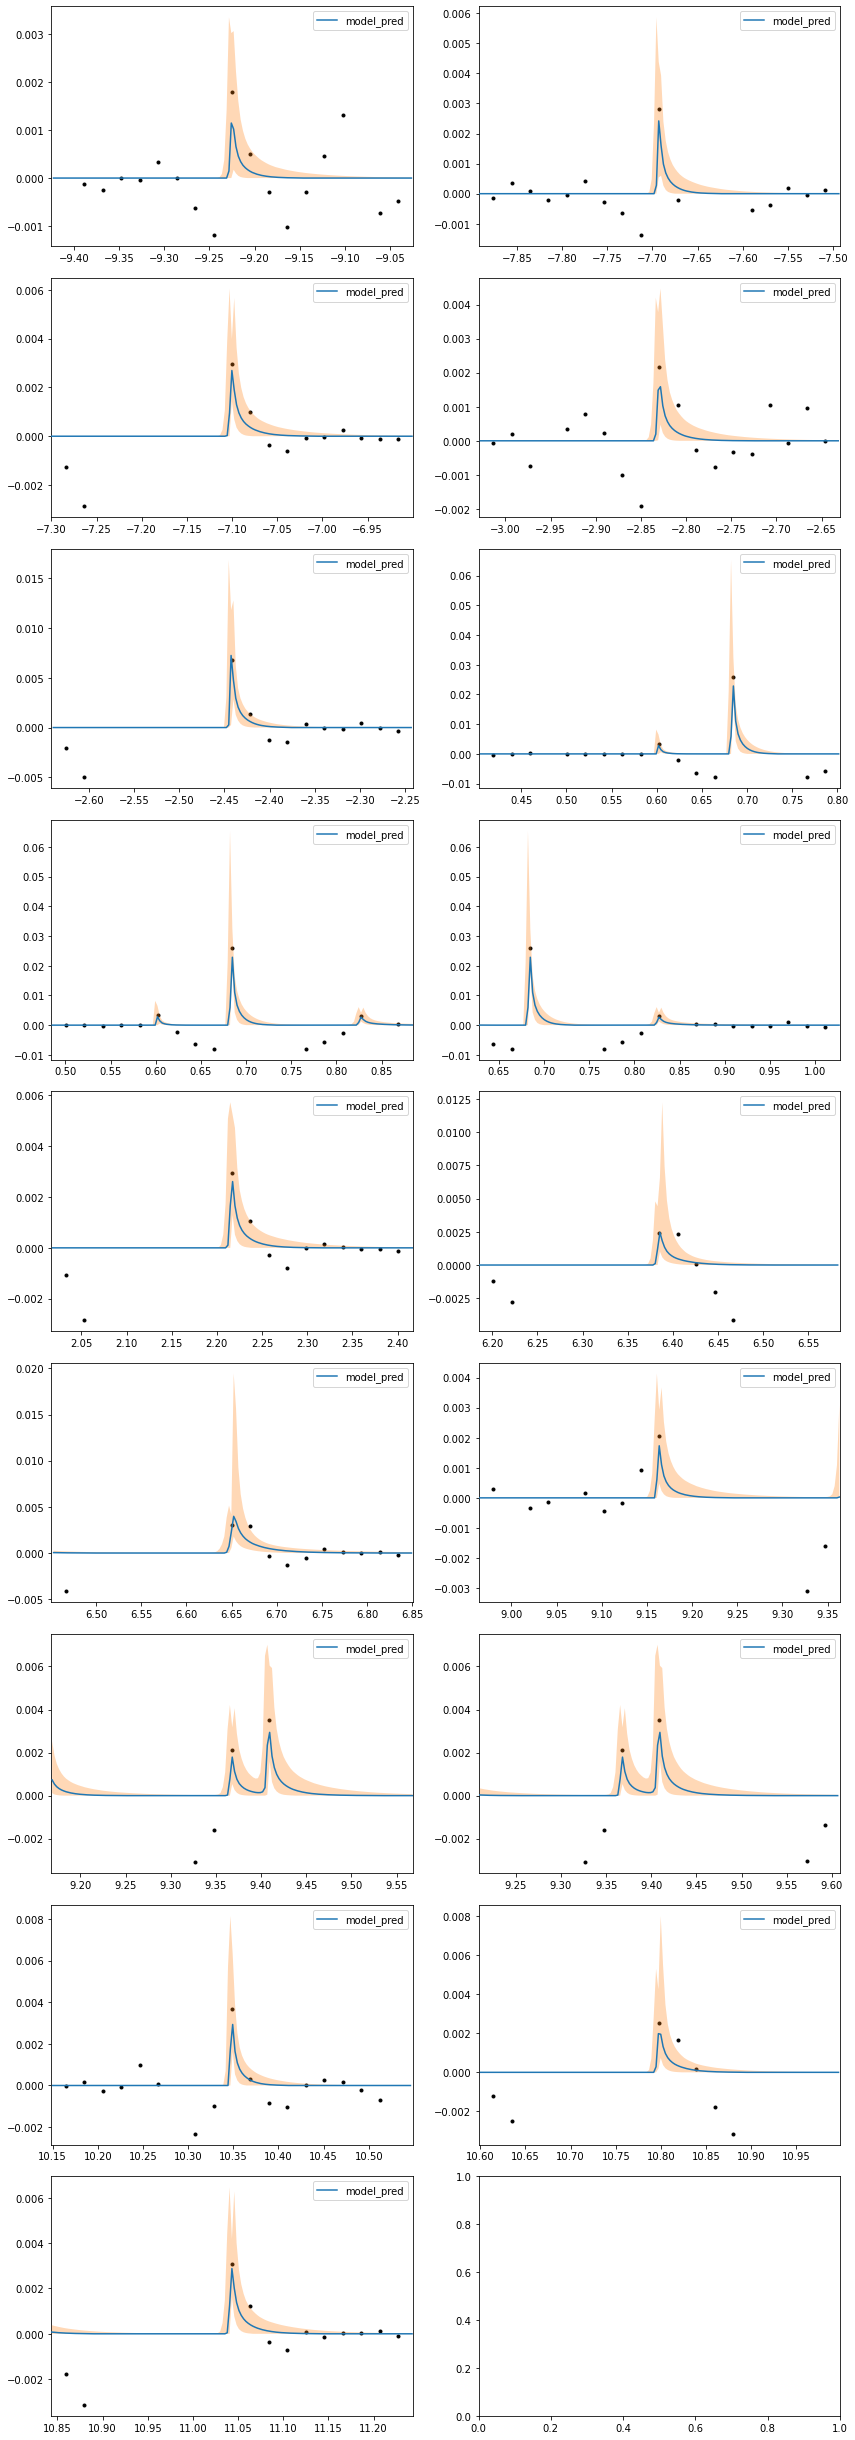

In [22]:
# make a fine grid that spans the observation window for plotting purposes
# from https://docs.exoplanet.codes/en/latest/tutorials/rv/
t_plot = np.linspace(x.min(), x.max(), 10000)

flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc = np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask_t_plot = (t_plot >= tpeaks[i]-0.2) * (t_plot < tpeaks[i]+0.2)
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    #ax.errorbar(x[timemask], y[timemask], yerr=yerr[timemask], fmt='.k')

    """
    with model:
        ax.plot(
            t_plot[timemask_t_plot], 
            pmx.eval_in_model(get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7), start)[timemask_t_plot], 
            "C1", label="model"
        )
    """
    #ax.plot(x[timemask], flc[1][timemask], label="model", zorder=1002)
    ax.plot(t_plot[timemask_t_plot], flc_plot[1][timemask_t_plot], label="model_pred", zorder=1001)
    art = ax.fill_between(t_plot[timemask_t_plot], 
                          flc_plot[0][timemask_t_plot],
                          flc_plot[2][timemask_t_plot], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()
    
fig.tight_layout()
fig.savefig('flare-model-postflare-postgap.png')

In [18]:
np.savez('pre_flare.npz', flc)
npzfile = np.load('pre_flare.npz')
npzfile['arr_0']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
len(npzfile['arr_0'][0])

1071

In [17]:
# save out to combine with other two set of flares
#pd.Series(flc[1]).to_csv('post-flare-post-gap-flares.csv', index=False)

In [191]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

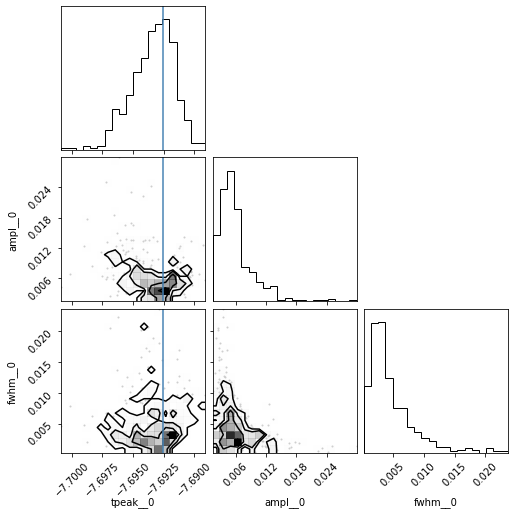

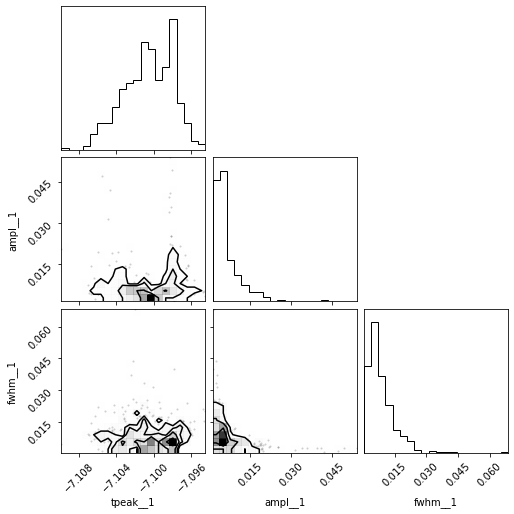

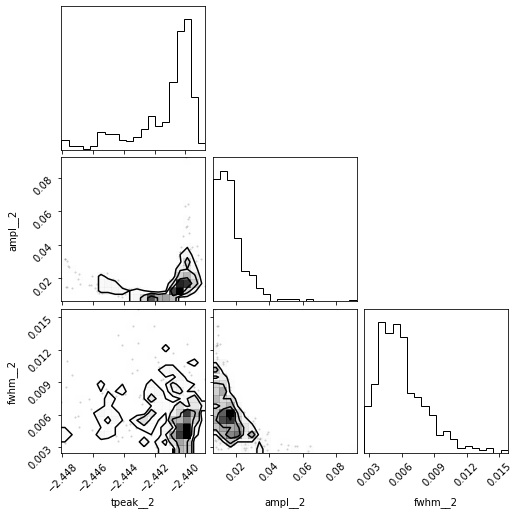

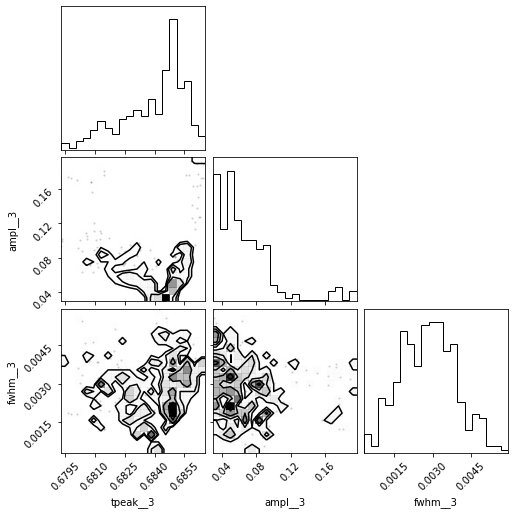

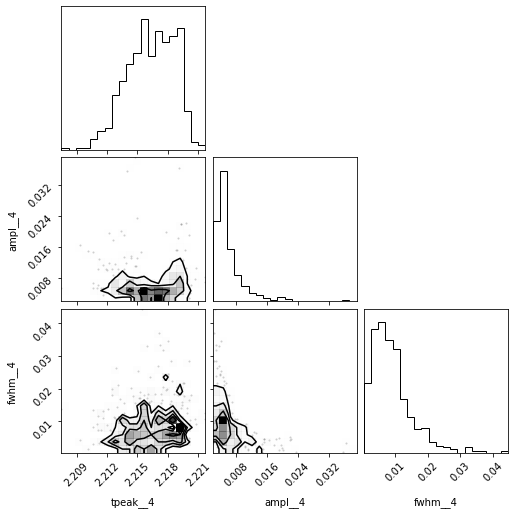

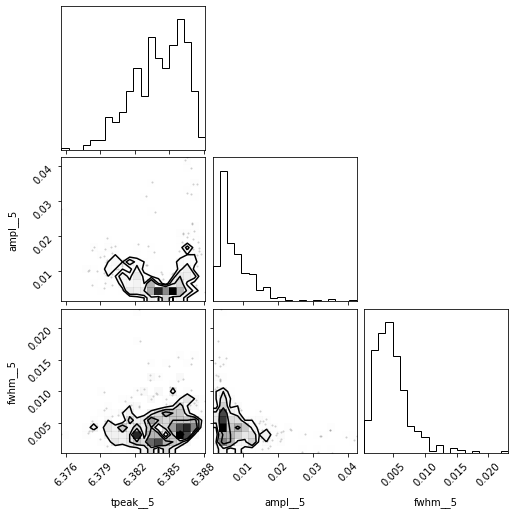

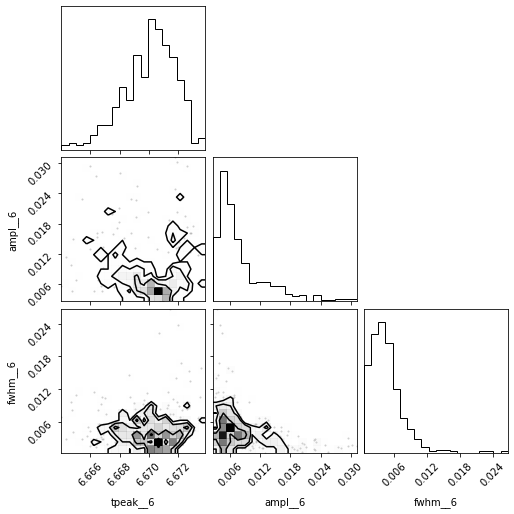

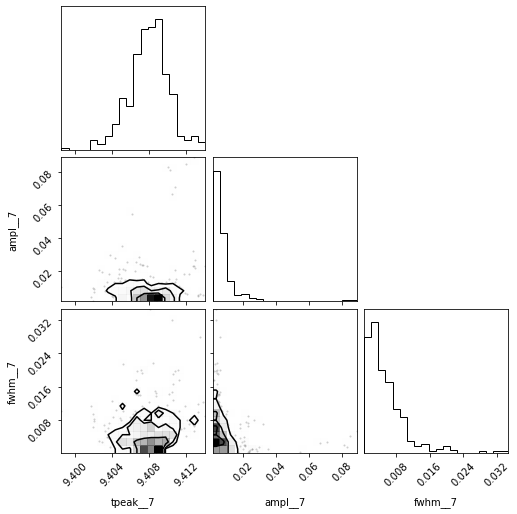

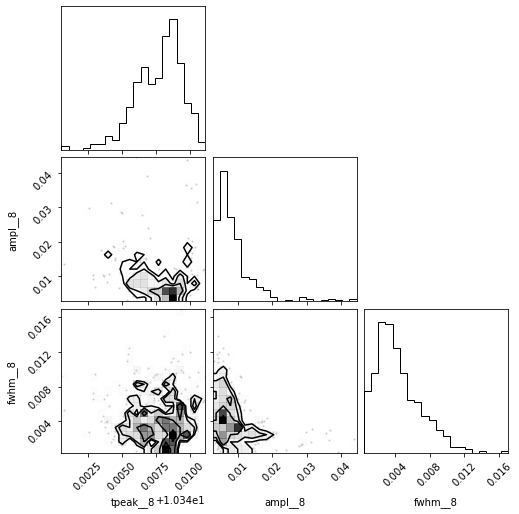

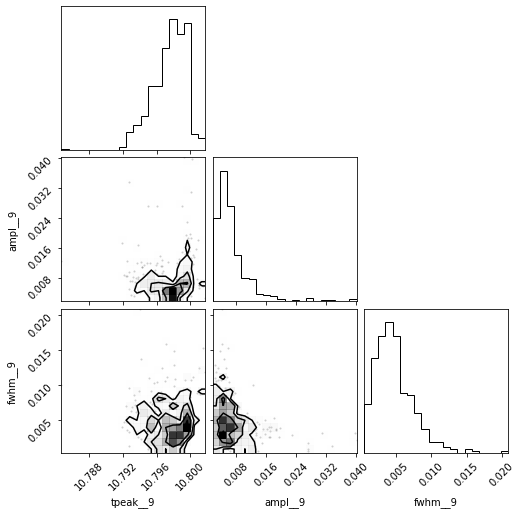

In [192]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

In [193]:
print(samples.head())
print(trace['tpeak'].shape[1])
print(['tpeak__{}'.format(i), 'ampl__{}'.format(i), 'fwhm__{}'.format(i)])

   tpeak__0  tpeak__1  tpeak__2  tpeak__3  tpeak__4  tpeak__5  tpeak__6  \
0 -7.692006 -7.102570 -2.441074  0.683456  2.215021  6.384930  6.669372   
1 -7.693338 -7.101636 -2.440913  0.683452  2.213357  6.382147  6.671575   
2 -7.692606 -7.097869 -2.440612  0.683315  2.213737  6.384017  6.669997   
3 -7.692712 -7.098876 -2.441176  0.683137  2.214807  6.386932  6.670717   
4 -7.692728 -7.099506 -2.440847  0.682890  2.214017  6.386169  6.671660   

   tpeak__7   tpeak__8   tpeak__9  ...   fwhm__0   fwhm__1   fwhm__2  \
0  9.409210  10.345609  10.799692  ...  0.003943  0.012089  0.005881   
1  9.410765  10.348330  10.797587  ...  0.006871  0.004753  0.010062   
2  9.409324  10.349236  10.798704  ...  0.015332  0.011699  0.010112   
3  9.409392  10.348691  10.799916  ...  0.002957  0.004812  0.002808   
4  9.408187  10.348737  10.799091  ...  0.000698  0.008818  0.002915   

    fwhm__3   fwhm__4   fwhm__5   fwhm__6   fwhm__7   fwhm__8   fwhm__9  
0  0.001017  0.000765  0.001169  0.004214 

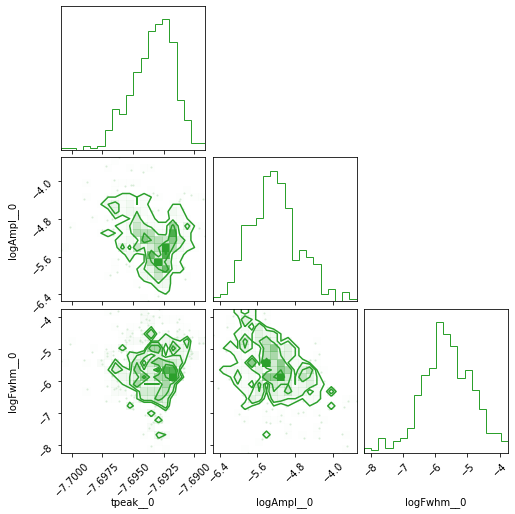

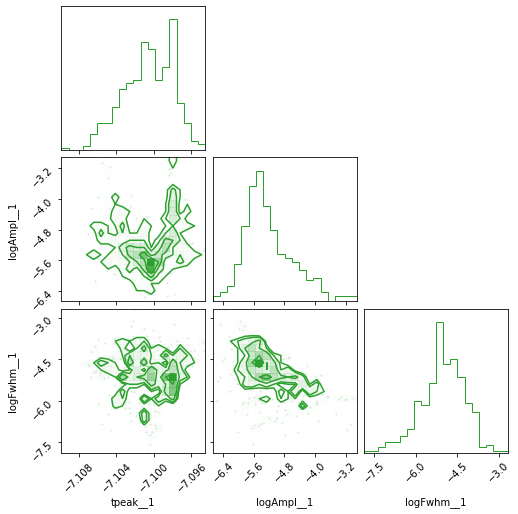

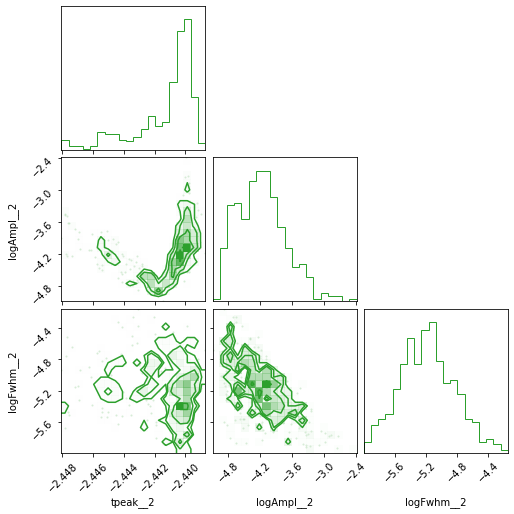

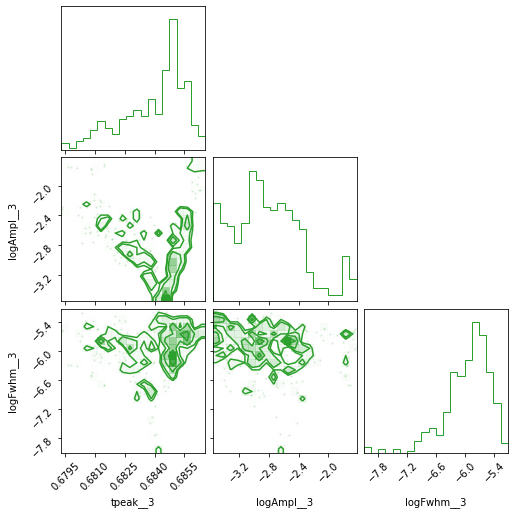

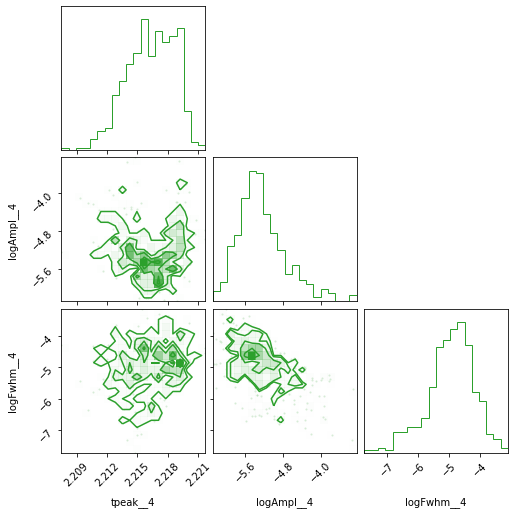

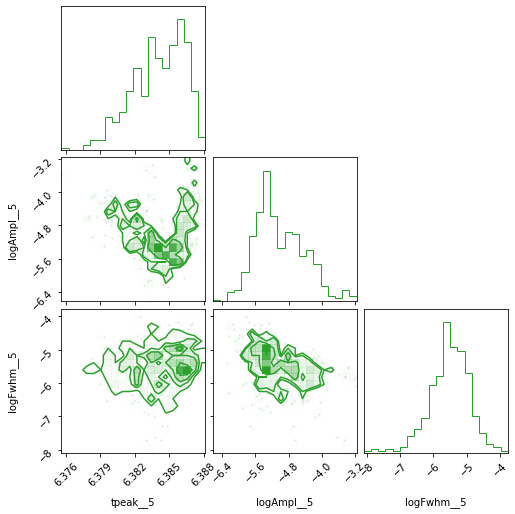

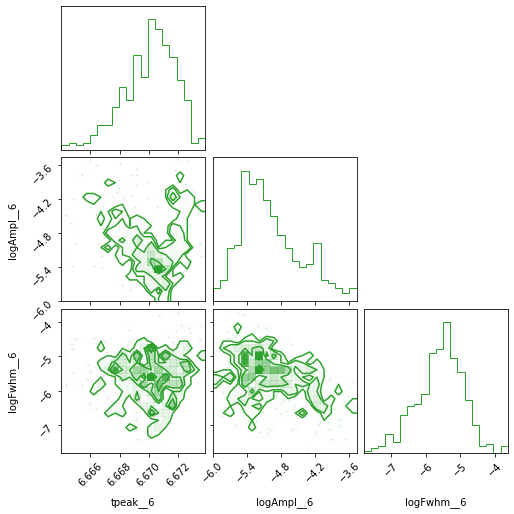

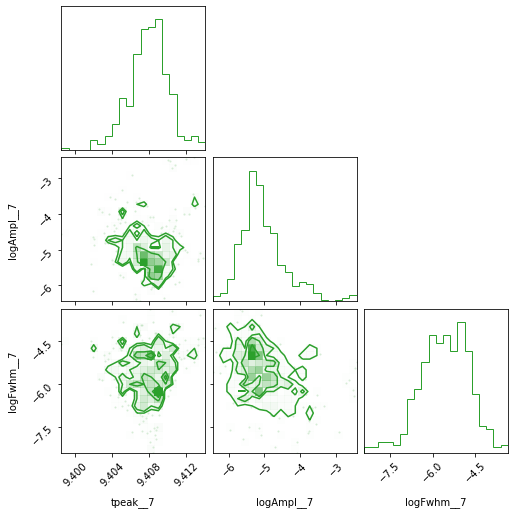

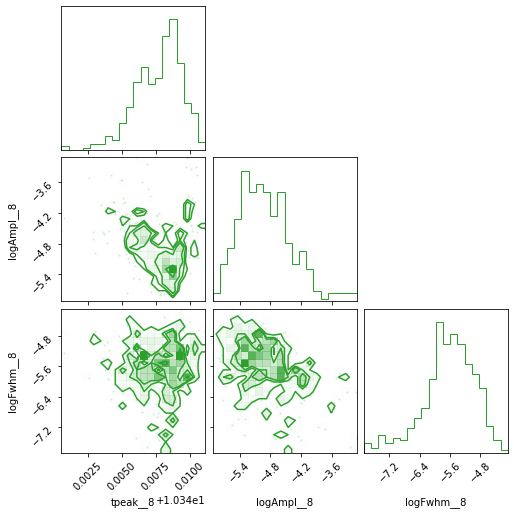

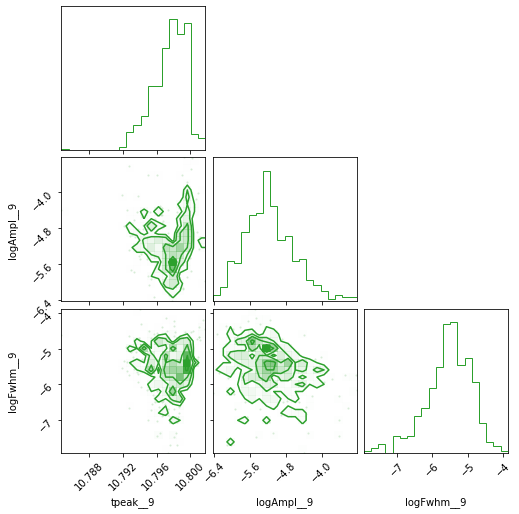

In [194]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

### Flare energies

In [23]:
# get equivalent durations
ed_model = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    
print(ed_model)

[2.6907635672195687, 5.385885646401816, 22.615218538618663, 3.9154669179618296, 54.688307154613895, 120.32183382269385, 127.72178148926434, 122.48109331153705, 22.728514264731636, 19.481396046676462, 30.245591112394948, 13.775155110044386, 10.6787332484198, 34.291197387027395, 6.651919361556354, 19.617533321042977, 24.356342560281885]


In [24]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    parallax = 21.6345 # in milliarcsecs (mas)
    distance = 22.74 # 46.22
    distance = 1./(parallax*0.001) # parsecs
    print(distance)
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # log erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
print("log flare energy: ", flare_energies)

46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [2.6907635672195687, 5.385885646401816, 22.615218538618663, 3.9154669179618296, 54.688307154613895, 120.32183382269385, 127.72178148926434, 122.48109331153705, 22.728514264731636, 19.481396046676462, 30.245591112394948, 13.775155110044386, 10.6787332484198, 34.291197387027395, 6.651919361556354, 19.617533321042977, 24.356342560281885]
log flare energy:  [31.52102197 31.82240356 32.44554722 31.68392999 32.82904091 33.17149088
 33.1974114  33.17921549 32.44771748 32.38076651 32.57180851 32.23024293
 32.11966617 32.62632908 31.91409341 32.38379083 32.47775851]


In [27]:
# get unnormalized times
tpeaks_unnormalized = [tpeak+calculate_ref_time(postgap) for tpeak in tpeaks]
fe_dict = {'time': tpeaks_unnormalized, 'flare_energies': flare_energies, 'ed': ed_model}
fe = pd.DataFrame(fe_dict)
print(fe)
fe.to_csv('flare_energies_postgap.csv')

           time  flare_energies          ed
0   2962.095770       31.521022    2.690764
1   2963.628134       31.822404    5.385886
2   2964.220649       32.445547   22.615219
3   2968.490843       31.683930    3.915467
4   2968.879042       32.829041   54.688307
5   2971.923348       33.171491  120.321834
6   2972.005074       33.197411  127.721781
7   2972.148096       33.179215  122.481093
8   2973.537445       32.447717   22.728514
9   2977.705499       32.380767   19.481396
10  2977.971111       32.571809   30.245591
11  2980.484208       32.230243   13.775155
12  2980.688525       32.119666   10.678733
13  2980.729389       32.626329   34.291197
14  2981.669248       31.914093    6.651919
15  2982.118746       32.383791   19.617533
16  2982.363927       32.477759   24.356343


### Subtract flare light curve

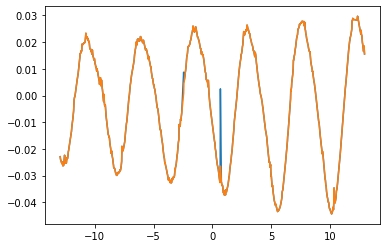

In [22]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve
plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

{'index': 123, 'log_power': -8.41554849094274, 'period': 4.565821917774273, 'period_uncert': 0.34604296835442233}


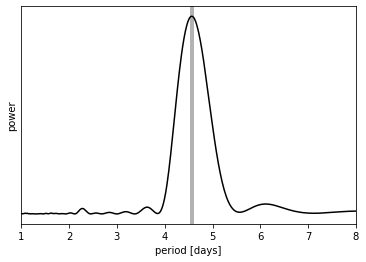

In [23]:
# periodogram
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

### Model flare-subtracted light curve with pyMC3 and GP likelihood

In [24]:
# get a smoothed version of the light curve
norm_y = normalize_flux(postgap.PDCSAP_FLUX)
norm_yerr = normalize_flux(postgap.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

2594   -0.022913
2595   -0.023527
2596   -0.024082
2597   -0.024281
2598   -0.024571
          ...   
3856    0.017221
3857    0.016522
3859    0.018569
3860    0.016874
3861    0.015584
Name: PDCSAP_FLUX, Length: 1071, dtype: float32
2594   -0.016280
2595   -0.016569
2596   -0.016873
2597   -0.016956
2598   -0.016995
          ...   
3856    0.023091
3857    0.022657
3859    0.023501
3860    0.022514
3861    0.022021
Name: PDCSAP_FLUX_ERR, Length: 1071, dtype: float32


In [26]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 898.1720987293585 -> 4176.720334360162


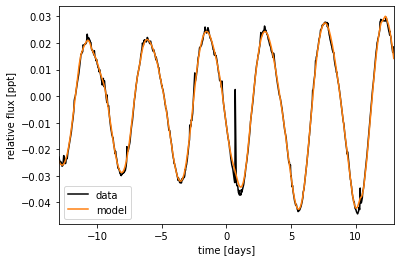

In [27]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.savefig('quiescent_gp_postgap.png')
plt.show()

In [28]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 552 seconds.


In [29]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.299,0.223,0.100,0.784,0.004,0.003,3560.0,3026.0,4520.0,3289.0,1.0
dQ,7.410,27.085,0.000,25.857,0.452,0.320,3590.0,3590.0,5126.0,3535.0,1.0
Q0,26144.971,26307.699,2006.131,65947.217,486.392,343.965,2925.0,2925.0,4148.0,2928.0,1.0
period,8.968,0.270,8.476,9.487,0.004,0.003,3600.0,3600.0,3936.0,2853.0,1.0
sigma_rot,1.171,0.158,0.872,1.460,0.002,0.002,5100.0,4777.0,5426.0,3526.0,1.0
rho,134.919,22.871,95.151,177.315,0.401,0.284,3248.0,3248.0,3381.0,3078.0,1.0
sigma,0.998,0.161,0.712,1.296,0.002,0.002,4986.0,4689.0,5247.0,3599.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,1249.0,1249.0,1454.0,565.0,1.0
mean,-0.003,0.021,-0.044,0.034,0.000,0.000,5546.0,2860.0,5546.0,3668.0,1.0


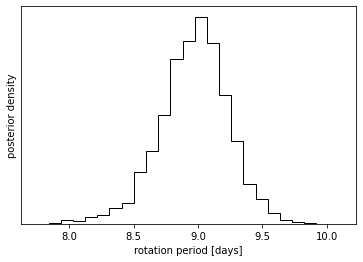

In [30]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.savefig("period_posterior_postgap.png")

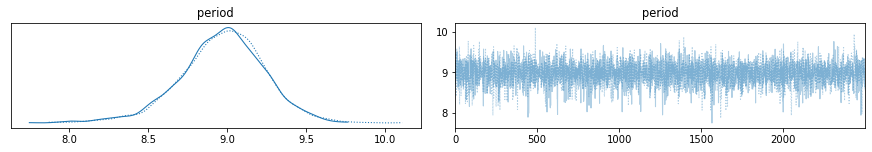

In [31]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])
plt.savefig("period_trace_postgap.png")

### Let's try this for the whole time series

##### Try with piecewise-connected-reindexed time series

In [100]:
lc_sans_gap = pd.concat([lc.loc[lc.TIME<=2953.105913], lc.loc[lc.TIME>=2958.377233]], ignore_index=True)

In [93]:
lc

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
1,2905.397662,0.005331,136856,614196.0000,22.708811,19530.005859,7.175916,612915.2500,22.353420,0,NaN,NaN,NaN,NaN,816.427351,0.000052,606.441413,0.000042,-0.095587,-0.096286
2,2905.418095,0.005329,136857,614179.6250,22.713530,19541.736328,7.180060,612892.8125,22.366695,0,NaN,NaN,NaN,NaN,816.405607,0.000052,606.435430,0.000042,-0.115562,-0.097267
3,2905.438527,0.005328,136858,614099.5000,22.717106,19533.994141,7.191803,612824.8125,22.378389,0,NaN,NaN,NaN,NaN,816.384126,0.000052,606.426319,0.000042,-0.135376,-0.097348
4,2905.458959,0.005327,136859,614238.1875,22.723835,19532.445312,7.191343,612975.3750,22.391329,0,NaN,NaN,NaN,NaN,816.363772,0.000052,606.415512,0.000042,-0.154696,-0.097495
5,2905.479392,0.005326,136860,614975.9375,22.748260,19513.044922,7.226193,613748.6875,22.427473,0,NaN,NaN,NaN,NaN,816.344506,0.000051,606.406872,0.000042,-0.172713,-0.097241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,2984.161921,-0.001930,140711,629914.1250,23.857279,56598.738281,8.155649,630960.5000,23.796947,0,NaN,NaN,NaN,NaN,816.360596,0.000057,606.498772,0.000046,-0.155825,-0.004180
3857,2984.182353,-0.001931,140712,629393.1875,23.852659,56688.351562,8.154782,630527.3750,23.786861,0,NaN,NaN,NaN,NaN,816.339762,0.000057,606.496000,0.000046,-0.175443,-0.001513
3859,2984.223216,-0.001935,140714,630402.6250,23.880606,56713.800781,8.171706,631796.7500,23.806480,0,NaN,NaN,NaN,NaN,816.285163,0.000057,606.480752,0.000047,-0.229627,0.002307
3860,2984.243648,-0.001937,140715,629185.0000,23.865633,56739.789062,8.163911,630745.3750,23.783533,0,NaN,NaN,NaN,NaN,816.261135,0.000057,606.476130,0.000047,-0.253859,0.004493


In [101]:
lc_sans_gap

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
0,2905.397662,0.005331,136856,614196.0000,22.708811,19530.005859,7.175916,612915.2500,22.353420,0,NaN,NaN,NaN,NaN,816.427351,0.000052,606.441413,0.000042,-0.095587,-0.096286
1,2905.418095,0.005329,136857,614179.6250,22.713530,19541.736328,7.180060,612892.8125,22.366695,0,NaN,NaN,NaN,NaN,816.405607,0.000052,606.435430,0.000042,-0.115562,-0.097267
2,2905.438527,0.005328,136858,614099.5000,22.717106,19533.994141,7.191803,612824.8125,22.378389,0,NaN,NaN,NaN,NaN,816.384126,0.000052,606.426319,0.000042,-0.135376,-0.097348
3,2905.458959,0.005327,136859,614238.1875,22.723835,19532.445312,7.191343,612975.3750,22.391329,0,NaN,NaN,NaN,NaN,816.363772,0.000052,606.415512,0.000042,-0.154696,-0.097495
4,2905.479392,0.005326,136860,614975.9375,22.748260,19513.044922,7.226193,613748.6875,22.427473,0,NaN,NaN,NaN,NaN,816.344506,0.000051,606.406872,0.000042,-0.172713,-0.097241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,2984.161921,-0.001930,140711,629914.1250,23.857279,56598.738281,8.155649,630960.5000,23.796947,0,NaN,NaN,NaN,NaN,816.360596,0.000057,606.498772,0.000046,-0.155825,-0.004180
3251,2984.182353,-0.001931,140712,629393.1875,23.852659,56688.351562,8.154782,630527.3750,23.786861,0,NaN,NaN,NaN,NaN,816.339762,0.000057,606.496000,0.000046,-0.175443,-0.001513
3252,2984.223216,-0.001935,140714,630402.6250,23.880606,56713.800781,8.171706,631796.7500,23.806480,0,NaN,NaN,NaN,NaN,816.285163,0.000057,606.480752,0.000047,-0.229627,0.002307
3253,2984.243648,-0.001937,140715,629185.0000,23.865633,56739.789062,8.163911,630745.3750,23.783533,0,NaN,NaN,NaN,NaN,816.261135,0.000057,606.476130,0.000047,-0.253859,0.004493


In [102]:
x, y, tpeaks, ampls, fwhms, npeaks = find_flares(lc_sans_gap)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [121]:
max(lc.TIME) - min(lc.TIME)

78.86641734662408

##### Guess not. Let's just use the standard lc instead of lc_sans_gap

In [114]:
norm_y = normalize_flux(lc_sans_gap.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 13, polyorder=3)
resid = norm_y - smooth
mask = resid < 3.5*np.sqrt(np.mean(resid**2))

In [117]:
ref_time = calculate_ref_time(lc_sans_gap)
x = lc_sans_gap.TIME - ref_time # subtract time by average time
y = resid # data with savgol subtracted

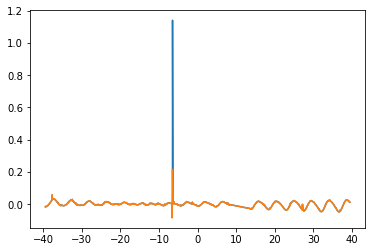

In [118]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve
plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

{'index': 393, 'log_power': -9.749128072292478, 'period': 4.457322327027283, 'period_uncert': 0.08707837229068789}


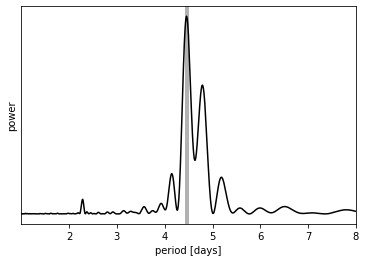

In [119]:
# periodogram
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

In [66]:
xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))


In [67]:
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8468708967688.13 -> -8448626363912.203
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448626363912.203 -> -8448617019698.606
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448617019698.606 -> -8448617019698.606
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -8448617019698.606 -> -8448617019698.606


Finished [100%]: Average Loss = -11,311


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


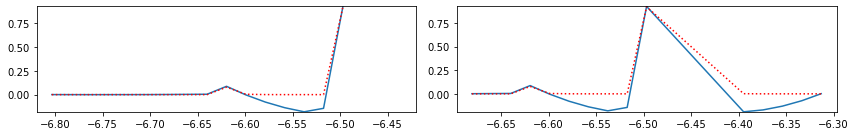

In [73]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

In [69]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 4 chains for 200 tune and 2_400 draw iterations (800 + 9_600 draws total) took 947 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


IndexError: index 5 is out of bounds for axis 0 with size 2

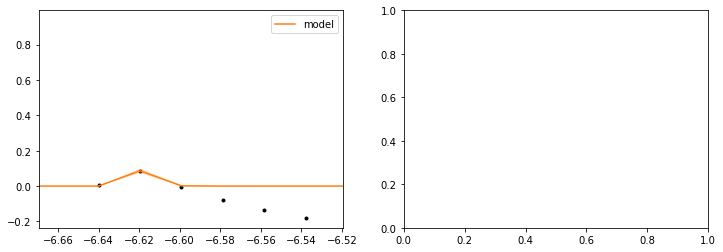

In [70]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks-1): # cause we double counted one
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.delaxes(axes[5])
fig.tight_layout()

In [ ]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

In [ ]:
# get a smoothed version of the light curve
norm_y = normalize_flux(lc.PDCSAP_FLUX)
norm_yerr = normalize_flux(lc.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

In [74]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 2830.2181504321493 -> 13875.256885852223


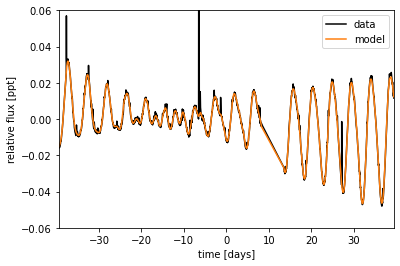

In [87]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.ylim(-0.06, 0.06)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.savefig('quiescent_gp.png')
plt.show()

In [80]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 438 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [81]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.229,0.144,0.100,0.511,0.003,0.002,2839.0,2839.0,2086.0,2305.0,1.0
dQ,6.751,30.742,0.001,21.509,0.488,0.345,3974.0,3974.0,6052.0,3006.0,1.0
Q0,496450.725,203857.047,190001.226,884796.408,4280.721,3324.400,2268.0,1881.0,2961.0,2438.0,1.0
period,4.565,0.032,4.508,4.627,0.000,0.000,5491.0,5491.0,5637.0,3063.0,1.0
sigma_rot,1.140,0.149,0.870,1.423,0.002,0.001,5870.0,5542.0,6162.0,3784.0,1.0
rho,1127.272,521.458,206.846,1969.750,13.790,9.753,1430.0,1430.0,1235.0,1055.0,1.0
sigma,1.006,0.162,0.728,1.329,0.002,0.002,4804.0,4384.0,5256.0,3247.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,5292.0,5292.0,5269.0,2978.0,1.0
mean,-0.004,0.022,-0.047,0.035,0.000,0.000,6511.0,2307.0,6542.0,3589.0,1.0


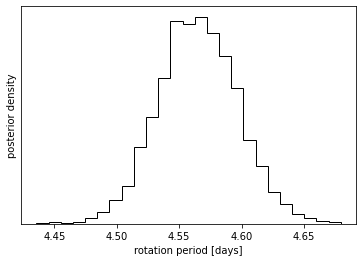

In [82]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.savefig("period_posterior_gp.png")

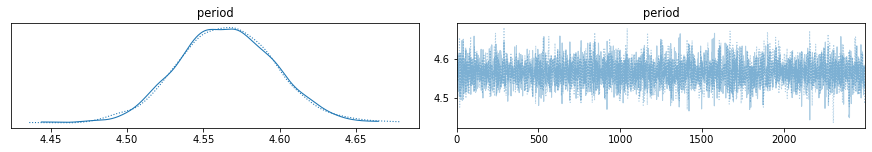

In [83]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])
plt.savefig("period_trace_gp.png")